# Generate figures for the p63 MPRA paper
## Firgure 1. Bibliographical information about p63 enhancers used in the study.

In [1]:
#import libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statannotations.Annotator import Annotator
import os
import textwrap
import numpy as np
#define useful functions
#set seaborn theme for nice figures
sns.set_theme(style="ticks",rc={"axes.spines.right": False, "axes.spines.top": False, 'font.size': 10},
			  font='arial')
#import key tables
os.chdir(r'Z:\gbaniulyte\MPRA\AM_STARRSeq\final_scripts_fastq\tables')
fig_out_path = r'Z:\gbaniulyte\MPRA\AM_STARRSeq\final_scripts_fastq\figures'
df = pd.read_csv('p63enh_starrseq_normCounts_matched_MCF10A_WTp53KO_5variants.csv', index_col=0)
df.sample(5)

,loc,enhancer_variant,cell_line,RNA/DNA,activity,obs_score,p63RE_class,strand,p63RE_type,gc,obs_p53
36542,chr1_202543798_202543822,shuffle,MCF10A,0.857604,Unchanged,9,primary,+,Unique p63RE,41.666667,NaN
61154,chr8_130058542_130058561,fullShuffle,MCF10A,0.977351,Unchanged,12,primary,-,p53RE+p63RE,46.218487,NaN
90488,chr2_73068332_73068351,mut,MCF10A p53KO,0.410317,Repressing,10,primary,+,p53RE+p63RE,47.899160,NaN
132170,chr8_10690955_10690974,fullShuffle,MCF10A p53KO,0.650375,Unchanged,10,quinary,-,Unique p63RE,55.462185,NaN
40077,chr3_31288746_31288760,shuffle,MCF10A,0.933683,Unchanged,8,tertiary,-,Unique p63RE,52.500000,NaN


In [4]:
#impact of enhancer distance to any transcript or TSS
import bioframe #deals with genomic ranges
#get genomic annotations
#dowloaded from https://hgdownload.cse.ucsc.edu/goldenpath/hg38/bigZips/genes/hg38.refGene.gtf.gz
gene_annot = r'Z:\gbaniulyte\genome_files\hg38.refGene.gtf'
genes = bioframe.read_table(gene_annot, schema='gtf').query('feature=="transcript"')
genes.drop_duplicates(subset = ['chrom','start','end'], inplace=True)
genes.drop(columns=['source', 'feature','score','frame'], inplace=True)
#only need unique enhancer locations
df_locs = df[['loc']].copy()
df_locs.drop_duplicates(inplace=True)
#extract p63RE coordinates
df_locs[['chrom','p63RE_start','p63RE_end']] = df_locs.apply(lambda row: row['loc'].split('_'),result_type='expand', axis='columns')
#ensure correct dtype for bioframe
df_locs = df_locs.astype({"p63RE_start": int, "p63RE_end": int})
#get a table with closest p63 enhancer distances to transcripts (start or end)
distance_tx = bioframe.closest(df_locs, genes,  cols1 = ['chrom','p63RE_start','p63RE_end'],
							  cols2 = ['chrom','start','end'], suffixes = ['','_transcript'])
distance_tx.rename(columns={'distance':'Distance to the nearest\ntranscript (nt)'}, inplace=True)
#get a table with closest p63 enhancer distances to TSS
genes['TSS'] = genes.apply(lambda row: row.start if row.strand  == '+' else row.end, axis='columns')
distance_tss = bioframe.closest(df_locs, genes,  cols1 = ['chrom','p63RE_start','p63RE_end'],
							  cols2 = ['chrom','TSS','TSS'], suffixes = ['','_TSS'])
distance_tss.rename(columns={'distance':'Distance to the nearest\nTSS (nt)'}, inplace=True)
#make a separate tabnle with custom ranges so that bar widths are the same
mybins = [-1,5000,10000,25000,50000,100000,250000,1500000]
bin_labels = ['0 - 5k', '5 - 10k', '10 - 25k', '25- 50k','50 - 100k', '100 - 250k', '250k+']
binned_dist_tx = pd.cut(distance_tx['Distance to the nearest\ntranscript (nt)'], bins=mybins, labels = bin_labels)
distance_tx['rel_to_gene'] = distance_tx['Distance to the nearest\ntranscript (nt)'].apply(lambda x: 'Intragenic' if x == 0 else 'Intergenic')
binned_dist_tss = pd.cut(distance_tss['Distance to the nearest\nTSS (nt)'], bins=mybins, labels = bin_labels)
distance_tx.sample(5)

,loc,chrom,p63RE_start,p63RE_end,chrom_transcript,start_transcript,end_transcript,strand_transcript,attributes_transcript,Distance to the nearest\ntranscript (nt),rel_to_gene
13489,chr9_69009876_69009900,chr9,69009876,69009900,chr9,68705414,69009176,+,"gene_id ""PIP5K1B""; transcript_id ""NM_001278253...",700,Intergenic
8841,chr3_32296453_32296472,chr3,32296453,32296472,chr3,32238679,32370326,+,"gene_id ""CMTM8""; transcript_id ""NM_001320308"";...",0,Intragenic
10569,chr5_89181702_89181721,chr5,89181702,89181721,chr5,88883330,89467581,+,"gene_id ""MEF2C-AS1""; transcript_id ""NR_136218""...",0,Intragenic
11321,chr6_30102172_30102186,chr6,30102172,30102186,chr6,30102897,30113090,-,"gene_id ""TRIM31""; transcript_id ""NM_007028_2"";...",711,Intergenic
5000,chr16_88685706_88685725,chr16,88685706,88685725,chr16,88663373,88687188,+,"gene_id ""SNAI3-AS1""; transcript_id ""NR_024399""...",0,Intragenic


C:\Users\gaban\AppData\Local\Temp\ipykernel_4624\1107460978.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


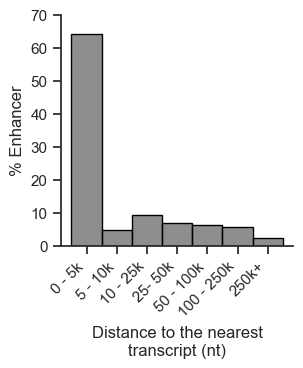

In [30]:
#plot Figure 1C
fig1C, ax = plt.subplots(figsize=(3,3))
sns.histplot(binned_dist_tx, stat='percent', color = 'dimgrey', linewidth = 1, edgecolor = 'black', ax=ax).set(ylabel = '% Enhancer', ylim = (0,70))
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
fig1C.savefig(os.path.join(fig_out_path,'1C_20240430.eps'), dpi=300, transparent=True, bbox_inches='tight')

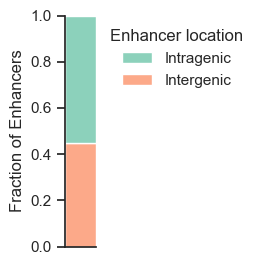

In [15]:
#plot Figure 1D v2. Stacked bar chart of intragenic and intergenic
fig_out_path = r'Z:\gbaniulyte\MPRA\AM_STARRSeq\final_scripts_fastq\figures'
#need place holder for the stacked barchart
distance_tx['xlabel'] = 'xlabel'
fig1D, ax = plt.subplots(figsize=(0.4,3))
sns.histplot(
    data=distance_tx,
    x="xlabel", hue="rel_to_gene",
    multiple="fill", stat="percent", palette= 'Set2',
    discrete=True, shrink=.6,ax=ax).set(ylabel = 'Fraction of Enhancers',xlabel=None)
ax.axes.get_xaxis().set_visible(False)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1), frameon=False, title = 'Enhancer location')
fig1D.savefig(os.path.join(fig_out_path,'1D_20240502.pdf'), dpi=300, transparent=True, bbox_inches='tight')

In [8]:
distance_tx.rel_to_gene.value_counts()

Intragenic    7538
Intergenic    6158
Name: rel_to_gene, dtype: int64

C:\Users\gaban\AppData\Local\Temp\ipykernel_4624\1874678982.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


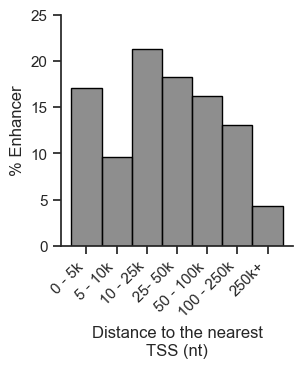

In [29]:
#plot Figure 1D
fig1D, ax = plt.subplots(figsize=(3,3))
sns.histplot(binned_dist_tss, stat='percent', color = 'dimgrey', linewidth = 1, edgecolor = 'black', ax=ax).set(ylabel = '% Enhancer', ylim = (0,25))
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
fig1D.savefig(os.path.join(fig_out_path,'1D_20240430.eps'), dpi=300, transparent=True, bbox_inches='tight')

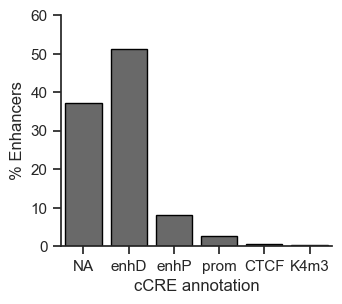

In [35]:
# Figure 1E. cCREs
df_cre = pd.read_csv('p63MPRA_regions_cCRE_numbers.04jan2024.csv', index_col=0)
df_cre.replace({np.nan : 'NA'}, inplace=True)
df_cre['% Enhancers'] = (df_cre.n / df_cre.n.sum()) * 100

fig1E, ax = plt.subplots(figsize=(3.5,3))
sns.barplot(data=df_cre, x='ucsc_label', y='% Enhancers',order=['NA', 'enhD', 'enhP', 'prom', 'CTCF', 'K4m3'],
			color = 'dimgrey',linewidth = 1, edgecolor = 'black', ax=ax).set(xlabel = 'cCRE annotation', ylim=(0,60), ylabel = '% Enhancers')
fig1E.savefig(os.path.join(fig_out_path,'1E_20240430.eps'), dpi=300, transparent=True, bbox_inches='tight')

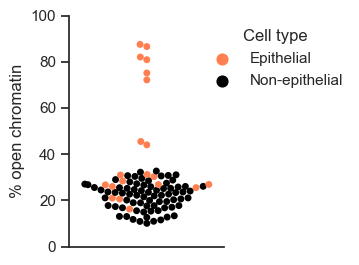

In [23]:
df_cell = pd.read_csv('dhs_count_by_cell_type.04jan2024.csv', index_col=0).reset_index()
df_cell.drop(columns='index', inplace=True)
df_cell['xlabel'] = 'xlabel'
df_cell['% open'] = (df_cell.open / (df_cell.closed + df_cell.open)) * 100
fig1F, ax = plt.subplots(figsize=(2,3))
sns.swarmplot(data=df_cell, x = 'xlabel',y='% open', hue='epi_cell',palette={'Epithelial':'coral', 'Non-epithelial':'black'}, ax=ax).set(ylabel = '% open chromatin', xlabel = 'Cell Types', ylim=(0,100))
sns.move_legend(ax, "upper left", bbox_to_anchor=(0.8, 1), frameon=False, title = 'Cell type')
ax.axes.get_xaxis().set_visible(False)
fig1F.savefig(os.path.join(fig_out_path,'1F_20240430.eps'), dpi=300, transparent=True, bbox_inches='tight')

c:\Users\gaban\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 21.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
c:\Users\gaban\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 11.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


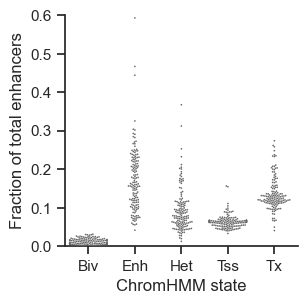

In [41]:
#plot Figure 1G
chrhmm = pd.read_csv('Percent_chromHMM_by_cell_type.for_heatmap.csv', index_col=0)
chrhmm_long = chrhmm.melt(id_vars=['Biosample.term.name'], value_vars=['Biv', 'Enh', 'Het','Tss', 'Tx'], var_name='ChromHMM state', value_name='Fraction of total')
fig1G, ax = plt.subplots(figsize=(3,3))
sns.swarmplot(data=chrhmm_long, x='ChromHMM state', y='Fraction of total', color = 'dimgrey',size=1.2, ax=ax).set(ylim=(0,0.6),ylabel='Fraction of total enhancers')
fig1G.savefig(os.path.join(fig_out_path,'1G_20240430.eps'), dpi=300, transparent=True, bbox_inches='tight')
#sns.color_palette(palette='binary')[-2]

In [52]:
chrhmm = pd.read_csv('Percent_chromHMM_by_cell_type.for_heatmap.csv', index_col=0)
chrhmm.head(5)

,Biosample.term.name,Biv,Enh,Het,Quies,Tss,Tx,ZNF/Rpts
1,HPDE6-E6E7,0.006926,0.593089,0.036764,0.211752,0.094002,0.049627,0.007840
2,RWPE2,0.005480,0.466966,0.039884,0.285736,0.154514,0.040798,0.006622
3,MCF10A,0.004377,0.444303,0.060531,0.261798,0.111071,0.112289,0.003711
4,RWPE1,0.005024,0.325468,0.019866,0.472446,0.104887,0.067514,0.004795
5,H54,0.029761,0.304004,0.044147,0.418329,0.088446,0.110367,0.004947


In [42]:
#reshape table for stacked barchart
chrhmm_long = chrhmm.melt(id_vars=['Biosample.term.name'], value_vars=['Biv', 'Enh','Quies', 'Het','Tss', 'Tx'], var_name='ChromHMM state', value_name='Fraction of total')
chrhmm_long['xlabel'] = chrhmm_long['Biosample.term.name'].apply(lambda x: 'MCF10A' if x == 'MCF10A' else 'ENCODE\naverage') #\n to break up xlabel
chrhmm_long.head(5)

,Biosample.term.name,ChromHMM state,Fraction of total,xlabel
0,HPDE6-E6E7,Biv,0.006926,ENCODE\naverage
1,RWPE2,Biv,0.005480,ENCODE\naverage
2,MCF10A,Biv,0.004377,MCF10A
3,RWPE1,Biv,0.005024,ENCODE\naverage
4,H54,Biv,0.029761,ENCODE\naverage


In [43]:
collapsed = chrhmm_long.groupby(['xlabel','ChromHMM state'])['Fraction of total'].mean().to_frame().reset_index()
collapsed.sample(5)


,xlabel,ChromHMM state,Fraction of total
0,ENCODE\naverage,Biv,0.012501
1,ENCODE\naverage,Enh,0.170310
11,MCF10A,Tx,0.112289
3,ENCODE\naverage,Quies,0.515382
2,ENCODE\naverage,Het,0.094196


In [44]:
tbl = collapsed.pivot(index='xlabel', columns='ChromHMM state', values='Fraction of total')
tbl

ChromHMM state,Biv,Enh,Het,Quies,Tss,Tx
xlabel,,,,,,
ENCODE\naverage,0.012501,0.170310,0.094196,0.515382,0.063358,0.135548
MCF10A,0.004377,0.444303,0.060531,0.261798,0.111071,0.112289


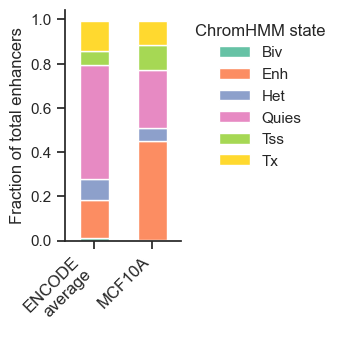

In [45]:
fig1H, ax = plt.subplots(figsize=(1.5,3))
tbl.plot(kind='bar', stacked=True, color = sns.color_palette(palette='Set2'), ax=ax).set(xlabel=None, ylabel='Fraction of total enhancers')
ax.set_xticklabels(ax.get_xticklabels(),rotation=45, size=12,ha='right')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1), frameon=False, title = 'ChromHMM state')
fig1H.savefig(os.path.join(fig_out_path,'1H_20240430.eps'), dpi=300, transparent=True, bbox_inches='tight')

In [10]:
#test for data normality to choose a statistical test
from scipy import stats
from scipy.stats import anderson
#stats.normaltest(df[(df.cell_line == 'MCF10A') & (df.enhancer_variant == 'mut')]['RNA/DNA'])
result = anderson(df[(df.cell_line == 'MCF10A') & (df.enhancer_variant == 'WT')]['RNA/DNA'])
print('Statistic: %.3f' % result.statistic)
p = 0
for i in range(len(result.critical_values)):
	sl, cv = result.significance_level[i], result.critical_values[i]
	if result.statistic < result.critical_values[i]:
		print('%.3f: %.3f, data looks normal (fail to reject H0)' % (sl, cv))
	else:
		print('%.3f: %.3f, data does not look normal (reject H0)' % (sl, cv))

Statistic: 1758.848
15.000: 0.576, data does not look normal (reject H0)
10.000: 0.656, data does not look normal (reject H0)
5.000: 0.787, data does not look normal (reject H0)
2.500: 0.918, data does not look normal (reject H0)
1.000: 1.092, data does not look normal (reject H0)


In [13]:
#run Kruskal-wallis comparison to see if there's a difference between all 5 variants in aggregate
stats.kruskal(df[(df.cell_line == 'MCF10A') & (df.enhancer_variant == 'flankShuffle')]['RNA/DNA'],
			  df[(df.cell_line == 'MCF10A') & (df.enhancer_variant == 'WT')]['RNA/DNA'],
			  df[(df.cell_line == 'MCF10A') & (df.enhancer_variant == 'mut')]['RNA/DNA'],
			  df[(df.cell_line == 'MCF10A') & (df.enhancer_variant == 'shuffle')]['RNA/DNA'],
			  df[(df.cell_line == 'MCF10A') & (df.enhancer_variant == 'fullShuffle')]['RNA/DNA'])

KruskalResult(statistic=2370.8184454468733, pvalue=0.0)

In [37]:
from scikit_posthocs import posthoc_dunn
# posthoc dunn test, with correction for multiple testing
dunn = posthoc_dunn(df[df.cell_line == 'MCF10A'], val_col="RNA/DNA", group_col="enhancer_variant", p_adjust="bonferroni")
dunn = dunn.melt(ignore_index=False).reset_index().dropna()
#only keep WT to other 4 variants comparison
dunn = dunn[(dunn.variable == 'WT') & (dunn['index'] != 'WT')]
dunn

,index,variable,value
1,flankShuffle,WT,8.143218e-11
2,fullShuffle,WT,3.292240e-34
3,mut,WT,2.082943e-237
4,shuffle,WT,3.621364e-171


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

WT vs. mut: Custom statistical test, P_val:2.083e-237
WT vs. shuffle: Custom statistical test, P_val:3.621e-171
WT vs. flankShuffle: Custom statistical test, P_val:8.143e-11
WT vs. fullShuffle: Custom statistical test, P_val:3.292e-34


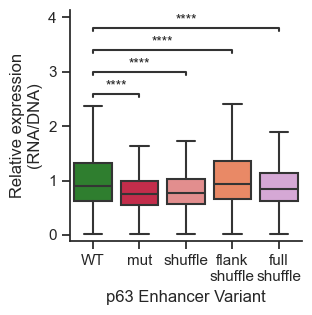

In [41]:
#set variables for stats to place on the graph
pairs = [(i[1]["index"], i[1]["variable"]) for i in dunn.iterrows()]
p_values = [i[1]["value"] for i in dunn.iterrows()]
cols = {'WT':'forestgreen', 'mut':'crimson', 'shuffle':'lightcoral','flankShuffle':'coral','fullShuffle':'plum'}
fig1J, ax = plt.subplots(figsize=(3,3))
sns.boxplot(data=df[df.cell_line == 'MCF10A'], x='enhancer_variant', y='RNA/DNA',
			showfliers = False, palette = cols,ax=ax).set(xlabel = 'p63 Enhancer Variant',
													 ylabel = 'Relative expression\n(RNA/DNA)',xticklabels=(['WT', 'mut','shuffle','flank\nshuffle','full\nshuffle']))
annotator = Annotator(ax=ax, pairs = pairs, data=df[df.cell_line == 'MCF10A'], x='enhancer_variant',y='RNA/DNA')
annotator.set_pvalues_and_annotate(p_values)
fig1J.savefig(os.path.join(fig_out_path,'1J_20240506.eps'), dpi=300, transparent=True, bbox_inches='tight')

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

WT vs. mut: Kruskal-Wallis independent samples (pairwise between groups) with Benjamini-Hochberg correction, P_val:1.288e-223 Stat=1.019e+03
WT vs. shuffle: Kruskal-Wallis independent samples (pairwise between groups) with Benjamini-Hochberg correction, P_val:1.358e-164 Stat=7.476e+02
WT vs. flankShuffle: Kruskal-Wallis independent samples (pairwise between groups) with Benjamini-Hochberg correction, P_val:1.591e-09 Stat=3.642e+01
WT vs. fullShuffle: Kruskal-Wallis independent samples (pairwise between groups) with Benjamini-Hochberg correction, P_val:4.053e-40 Stat=1.758e+02


(<Axes: xlabel='p63 Enhancer Variant', ylabel='Relative expression\n(RNA/DNA)'>,
  <statannotations.Annotation.Annotation at 0x1cd30c4fdf0>])

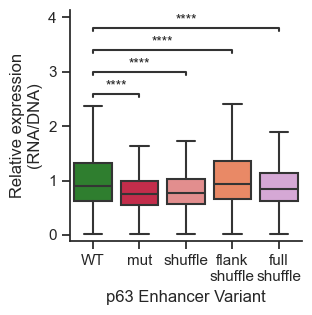

In [19]:
#Figure 1J. Boxplots
cols = {'WT':'forestgreen', 'mut':'crimson', 'shuffle':'lightcoral','flankShuffle':'coral','fullShuffle':'plum'}
fig1J, ax = plt.subplots(figsize=(3,3))
sns.boxplot(data=df[df.cell_line == 'MCF10A'], x='enhancer_variant', y='RNA/DNA',
			showfliers = False, palette = cols,ax=ax).set(xlabel = 'p63 Enhancer Variant',
													 ylabel = 'Relative expression\n(RNA/DNA)',xticklabels=(['WT', 'mut','shuffle','flank\nshuffle','full\nshuffle']))
compare = (['WT', 'mut'], ['WT', 'shuffle'],['WT', 'flankShuffle'],['WT', 'fullShuffle'])
annotator = Annotator(ax, compare, data=df[df.cell_line == 'MCF10A'], x='enhancer_variant',y='RNA/DNA')
annotator.configure(test="Kruskal",comparisons_correction="BH").apply_and_annotate()
#fig1J.savefig(os.path.join(fig_out_path,'1J_20240430.eps'), dpi=300, transparent=True, bbox_inches='tight')